MSE: 17.8891


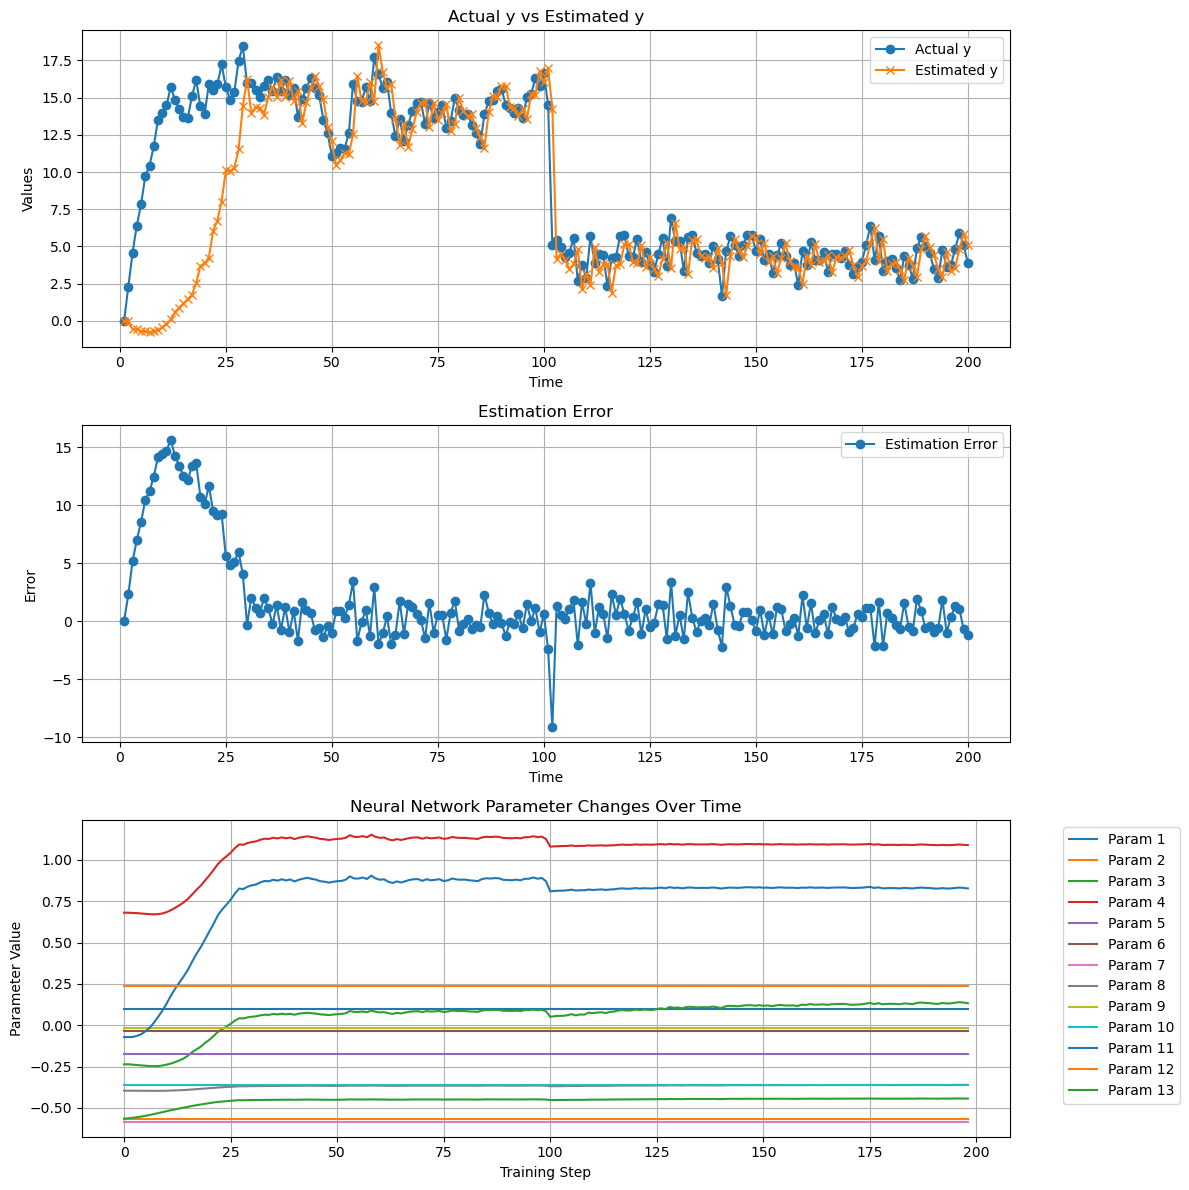

In [1]:
# Deep Learning 101 for Scientists and Engineers
# Chapter 3.4: Neural Network
# Yong-Jun Shin, 2024

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set the seed for reproducibility
torch.manual_seed(42)

# Number of simulation steps
N = 200

# Generate simulated N x values with normal distribution (mean=10, std=1)
x = torch.randn(N) + 10

# Initialize an empty tensor y with N values
y = torch.empty(N)

# Initial parameters for the gene network
P_xy = 0.3  # Example value for contribution of x[n-1]
P_y = 0.8   # Example value for contribution of y[n-1]

# Generate simulated y values based on the given formula
y[0] = 0.0  # Initialize the first value
y[1] = P_xy * x[0] + P_y * y[0] + torch.randn(1)  # Start the recursion using the initial x[0]

for i in range(2, N):
    if i > 100:
        # Change P_xy and P_y for i > 100
        P_xy = 0.4
        P_y = 0.1
    y[i] = P_xy * x[i - 1] + P_y * y[i - 1] + torch.randn(1)

# Define the neural network model
class GeneNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.relu1 = nn.ReLU()
        self.hidden_layer = nn.Linear(hidden_size, output_size)  # Hidden to output layer

    def forward(self, x):
        h = self.relu1(self.input_layer(x))
        y_est = self.hidden_layer(h)
        return y_est

# Generate the model
input_size = 2  # The number of input layer nodes (x[n-1] and y[n-1])
hidden_size = 3 # The number of hidden layer nodes (h1, h2 and h3)
output_size = 1 # The number of output layer nodes (y_est[n])
    
model = GeneNetworkModel(input_size, hidden_size, output_size)

# Define cost function and optimizer
MSE = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0002)

# Function to get model parameters as a flat array
def get_model_params(model):
    return torch.cat([param.view(-1) for param in model.parameters()])

# Store initial parameters
initial_params = get_model_params(model).detach().numpy()

# Simulation Loop
cumulative_cost = 0.0
y_est = torch.empty(N)  # To store estimated y values for plotting
param_history = [initial_params]  # List to store parameter changes

for i in range(2, N):
    inputs = torch.tensor([x[i-1], y[i-1]])
    output = torch.tensor([y[i]])
    
    estimated_output = model(inputs)
    cost = MSE(output, estimated_output)
    cumulative_cost += cost.item()
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    y_est[i] = estimated_output.item()
    
    # Store current parameters
    current_params = get_model_params(model).detach().numpy()
    param_history.append(current_params)

# Calculate the mean squared error (MSE)
mse = cumulative_cost / (N - 2)  # Adjusted to reflect starting from index 2
print(f'MSE: {mse:.4f}')

# Convert parameter history to a numpy array for easier plotting
param_history = np.array(param_history)

# Plot the results
time = torch.arange(1, N+1)
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(time.numpy(), y.numpy(), label='Actual y', marker='o')
plt.plot(time.numpy(), y_est.numpy(), label='Estimated y', marker='x')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual y vs Estimated y')
plt.legend()
plt.grid(True)

# Plot the estimation error
plt.subplot(3, 1, 2)
plt.plot(time.numpy(), y.numpy() - y_est.numpy(), label='Estimation Error', marker='o')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Estimation Error')
plt.legend()
plt.grid(True)

# Plot the neural network parameter changes
plt.subplot(3, 1, 3)
for i in range(param_history.shape[1]):
    plt.plot(param_history[:, i], label=f'Param {i+1}')
plt.xlabel('Training Step')
plt.ylabel('Parameter Value')
plt.title('Neural Network Parameter Changes Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

